In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torchvision
from torchsummary import summary

import random
import numpy as np
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

np.random.seed(4)

In [2]:
train_transform = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    tt.Grayscale(num_output_channels=3)
])
train_dataset = CIFAR10('./data/', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10('./data/', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)

classes = 10
batch_size = 64
epochs = 1
lr = 2e-2

In [4]:
total_train_size, total_test_size

(50000, 10000)

In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

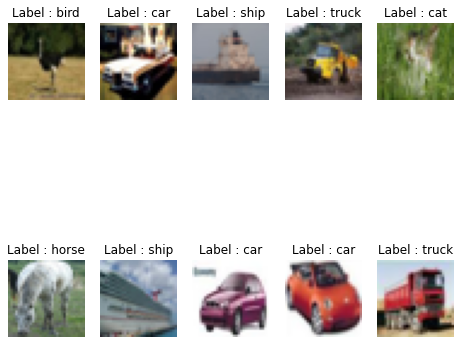

In [6]:
# Visualising 10 random sample from training data
indexes = np.random.randint(0, test_dataset.data.shape[0], size=10)

plt.figure(figsize=(8, 8))

for i in range(len(indexes)):
    sub = plt.subplot(2, 5, i + 1)
    image = test_dataset.data[indexes[i]]
    plt.imshow(image)
    plt.axis('off')
    sub.set_title("Label : " + str(classes[int(test_dataset.targets[indexes[i]])]))
plt.show()
plt.close('all')

In [10]:
def get_device():
    return torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [8]:
class Network_VGG():   
    model = None 
    def __init__(self):
        self.model = torchvision.models.vgg16(pretrained=False)
        self.model.classifier[6].out_features = 10
        self.model.to(device)
           
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
          _, predictions = torch.max(outputs, dim=1)
          return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self.model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        history = []

        for epoch in range(epochs):
          losses = []
          accs = []
          for batch in tqdm(dataloader):
            loss, acc = self._process_batch(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accs.append(acc)
          avg_loss = torch.stack(losses).mean().item()
          avg_acc = torch.stack(accs).mean().item()
          history.append((avg_loss, avg_acc))
          print('After Epoch  {}, train_loss = {},  train_acc = {}\n'.format(epoch, round(avg_loss, 4),round(avg_acc, 4)))
        return history

    def evaluate(self, dataset, batch_size=32):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
          for batch in dataloader:
            loss, acc= self._process_batch(batch)
            losses.append(loss)
            accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)  

In [9]:
net = Network_VGG()
epochs = 25
classes = 10
batch_size = 64
epochs = 20
lr = 2e-2

history = net.fit(train_dataset, epochs, lr, batch_size, opt=torch.optim.SGD)



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  0, train_loss = 2.2549,  train_acc = 0.251



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  1, train_loss = 1.5799,  train_acc = 0.4214



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  2, train_loss = 1.3806,  train_acc = 0.496



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  3, train_loss = 1.2154,  train_acc = 0.5637



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  4, train_loss = 1.0717,  train_acc = 0.6181



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  5, train_loss = 0.9453,  train_acc = 0.6641



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  6, train_loss = 0.8277,  train_acc = 0.7095



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  7, train_loss = 0.7362,  train_acc = 0.7406



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  8, train_loss = 0.6529,  train_acc = 0.7705



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  9, train_loss = 0.5748,  train_acc = 0.7972



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  10, train_loss = 0.4991,  train_acc = 0.8257



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  11, train_loss = 0.432,  train_acc = 0.8461



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  12, train_loss = 0.3657,  train_acc = 0.8694



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  13, train_loss = 0.3041,  train_acc = 0.8904



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  14, train_loss = 0.2493,  train_acc = 0.9125



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  15, train_loss = 0.2075,  train_acc = 0.9259



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  16, train_loss = 0.1769,  train_acc = 0.9375



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  17, train_loss = 0.1439,  train_acc = 0.9494



  0%|          | 0/782 [00:00<?, ?it/s]

After Epoch  18, train_loss = 0.1209,  train_acc = 0.9575



100%|██████████| 782/782 [13:04<00:00,  1.00s/it]


After Epoch  19, train_loss = 0.1054,  train_acc = 0.9627



In [10]:
torch.save(net.model.state_dict(), 'model_weights.pth')

In [11]:
net = Network_VGG()
net.model.load_state_dict(torch.load('model_weights.pth'))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 7; 10.92 GiB total capacity; 516.03 MiB already allocated; 13.38 MiB free; 520.00 MiB reserved in total by PyTorch)

In [ ]:
l = net.evaluate(test_dataset, batch_size=64)

In [ ]:
l

In [26]:
!pip install grad-cam
!pip install ttach

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because nor

In [27]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [70]:
target_layers = net.model.features[-1]

In [ ]:
cam = GradCAM(model=net.model, target_layer=target_layers,use_cuda=True)

In [76]:
image = k[0]

In [77]:
image.shape

torch.Size([32, 3, 224, 224])

In [ ]:
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=image)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [72]:
dataloader = DataLoader(train_dataset, batch_size = 32)

In [73]:
for k in dataloader:
    print(k[0].shape)
    break

torch.Size([32, 3, 224, 224])


In [34]:
net.model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [40]:
# import required modules
import inspect

# use getargspec()
print(inspect.getargspec(GradCAM))


ArgSpec(args=['self', 'model', 'target_layer', 'use_cuda', 'reshape_transform'], varargs=None, keywords=None, defaults=(False, None))


In [146]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
from torchvision.models import resnet50


In [160]:
model = resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [161]:
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [162]:
target_layers = model.layer4[-1]

In [163]:
model.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [177]:
cam = GradCAMPlusPlus(model=model, target_layer=target_layers, use_cuda=True)

In [178]:
image.shape

(32, 32, 3)

In [179]:
import cv2
rgb_img = cv2.resize(image, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])

In [180]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [181]:
target_category = None

In [182]:
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category,aug_smooth=True , eigen_smooth=True)

In [183]:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
cv2.imwrite('cam.jpg', cam_image)

True

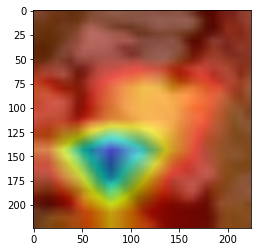

In [184]:
plt.imshow(cam_image)

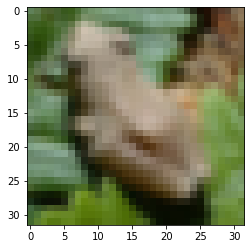

In [185]:
plt.imshow(image)